In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,f1_score,precision_score, recall_score,
    mean_squared_error, r2_score, roc_curve, auc, mean_absolute_error, silhouette_score
)
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import davies_bouldin_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
class MLProjectPipeline:
    
    def __init__(self, data, encoder=None, scaler=None, best_clustering_model=None,product_model_map=None):
        """
        data: DataFrame for this pipeline run
        encoder, scaler,product_model_map: Pass from training pipeline when running on test data
        best_clustering_model: Pass from training pipeline when predicting on test data
        """
        self.data = data
        self.encoder = encoder
        self.scaler = scaler
        self.feature_columns = None
        self.numeric_cols = None
        self.best_clustering_model = best_clustering_model
        self.product_model_map = product_model_map
#----save model-----
    def save_object(self, obj, filename):
        joblib.dump(obj, filename)
        print(f"✅ Saved: {filename}")
    
    def load_object(self, filename):
        if os.path.exists(filename):
            print(f"✅ Loaded: {filename}")
            return joblib.load(filename)
        else:
            print(f"⚠️ File not found: {filename}")
            return None

 # ------------------- Cleaning -------------------

    def clean_data(self, df=None):
        """
        Remove duplicates and handle missing values.
        If df is None, clean self.data; otherwise, clean the given DataFrame.
        """
        if df is None:
            df = self.data
    
        # Remove duplicates
        df.drop_duplicates(inplace=True)
    
        # Handle missing values
        if df.isnull().sum().any():
            df.fillna(method='ffill', inplace=True)
    
        if df is self.data:
            self.data = df
    
        return df

# ------------------- Session Features -------------------

    def add_session_features(self, df=None):
            
        """
        Add session-based features:
        - session_length: number of rows per session
        - total_clicks: number of clicks per session
        
        Works on self.data (train) or an external DataFrame (test).
        """
        if df is None:
            df = self.data
    
        if 'session_id' not in df.columns:
            raise ValueError("'session_id' column is required to compute session features.")
    
        # Session length
        session_length = df.groupby('session_id').size().reset_index(name='session_length')
    
        # Total clicks (assuming 'page' column represents clicks)
        if 'page' in df.columns:
            session_clicks = df.groupby('session_id')['page'].count().reset_index(name='total_clicks')
        else:
            session_clicks = pd.DataFrame({'session_id': df['session_id'].unique(), 'total_clicks': 0})
    
        # Merge into main DataFrame
        df = df.merge(session_length, on='session_id', how='left')
        df = df.merge(session_clicks, on='session_id', how='left')
    
        if df is self.data:
            self.data = df
    
        return df
#------------------------Encoding supervised model----------
    def encode_columns_supervised(self):
        continent_map = {
            'Australia': 'Oceania',
            'Austria': 'Europe',
            'Belgium': 'Europe',
            'British Virgin Islands': 'North America',
            'Cayman Islands': 'North America',
            'Christmas Island': 'Asia',
            'Croatia': 'Europe',
            'Cyprus': 'Asia',
            'Czech Republic': 'Europe',
            'Denmark': 'Europe',
            'Estonia': 'Europe',
            'unidentified': 'Other',
            'Faroe Islands': 'Europe',
            'Finland': 'Europe',
            'France': 'Europe',
            'Germany': 'Europe',
            'Greece': 'Europe',
            'Hungary': 'Europe',
            'Iceland': 'Europe',
            'India': 'Asia',
            'Ireland': 'Europe',
            'Italy': 'Europe',
            'Latvia': 'Europe',
            'Lithuania': 'Europe',
            'Luxembourg': 'Europe',
            'Mexico': 'North America',
            'Netherlands': 'Europe',
            'Norway': 'Europe',
            'Poland': 'Europe',
            'Portugal': 'Europe',
            'Romania': 'Europe',
            'Russia': 'Asia',
            'San Marino': 'Europe',
            'Slovakia': 'Europe',
            'Slovenia': 'Europe',
            'Spain': 'Europe',
            'Sweden': 'Europe',
            'Switzerland': 'Europe',
            'Ukraine': 'Europe',
            'United Arab Emirates': 'Asia',
            'United Kingdom': 'Europe',
            'USA': 'North America',
            'biz (.biz)': 'Other',
            'com (.com)': 'Other',
            'int (.int)': 'Other',
            'net (.net)': 'Other',
            'org (*.org)': 'Other'
        }

        country_dict = {i+1: name for i, name in enumerate(continent_map.keys())}

        self.data['country_name'] = self.data['country'].map(country_dict)
        self.data['continent'] = self.data['country_name'].map(continent_map)

        self.data = pd.get_dummies(self.data, columns=['continent'], drop_first=True)
        self.data = pd.get_dummies(self.data, columns=['page1_main_category'], prefix='main_cat')
        self.data = pd.get_dummies(self.data, columns=['colour'], prefix='colour')
        self.data = pd.get_dummies(self.data, columns=['location'], prefix='location')

        self.data['model_photography_encoded'] = self.data['model_photography'].map({1: 0, 2: 1})
        self.data['price_2_encoded'] = self.data['price_2'].map({1: 1, 2: 0})
        self.data['product_model_encoded'] = self.data['page2_clothing_model'].map(
            self.data['page2_clothing_model'].value_counts().to_dict()
        )

        self.data.drop(['model_photography', 'price_2', 'page2_clothing_model', 'country_name'], axis=1, inplace=True)
        return self
 # ------------------- Encoding clustering-------------------

    def encode_columns_unsupervised (self, df=None, fit=True):
        """
        Encode categorical variables. 
        - If fit=True, learns encoding from the data (for training set).
        - If fit=False, applies previously learned encoding (for test set).
        """
        if df is None:
            df = self.data
    
        # 1. Map country to continent
        continent_map = {
            'Australia': 'Oceania', 'Austria': 'Europe', 'Belgium': 'Europe',
            'British Virgin Islands': 'North America', 'Cayman Islands': 'North America',
            'Christmas Island': 'Asia', 'Croatia': 'Europe', 'Cyprus': 'Asia',
            'Czech Republic': 'Europe', 'Denmark': 'Europe', 'Estonia': 'Europe',
            'unidentified': 'Other', 'Faroe Islands': 'Europe', 'Finland': 'Europe',
            'France': 'Europe', 'Germany': 'Europe', 'Greece': 'Europe',
            'Hungary': 'Europe', 'Iceland': 'Europe', 'India': 'Asia', 'Ireland': 'Europe',
            'Italy': 'Europe', 'Latvia': 'Europe', 'Lithuania': 'Europe', 'Luxembourg': 'Europe',
            'Mexico': 'North America', 'Netherlands': 'Europe', 'Norway': 'Europe',
            'Poland': 'Europe', 'Portugal': 'Europe', 'Romania': 'Europe', 'Russia': 'Asia',
            'San Marino': 'Europe', 'Slovakia': 'Europe', 'Slovenia': 'Europe',
            'Spain': 'Europe', 'Sweden': 'Europe', 'Switzerland': 'Europe',
            'Ukraine': 'Europe', 'United Arab Emirates': 'Asia', 'United Kingdom': 'Europe',
            'USA': 'North America', 'biz (.biz)': 'Other', 'com (.com)': 'Other',
            'int (.int)': 'Other', 'net (.net)': 'Other', 'org (*.org)': 'Other'
        }
    
        country_dict = {i+1: name for i, name in enumerate(continent_map.keys())}
        df['country_name'] = df['country'].map(country_dict)
        df['continent'] = df['country_name'].map(continent_map)
    
        # 2. One-hot encode (fit on train, apply on test)
        cat_cols = ['continent', 'page1_main_category', 'colour', 'location']
    
        if fit:
            self.encoder = {}
            for col in cat_cols:
                dummies = pd.get_dummies(df[col], prefix=col, drop_first=True)
                self.encoder[col] = dummies.columns  # store column names
                df = pd.concat([df, dummies], axis=1)
        else:
            for col in cat_cols:
                dummies = pd.get_dummies(df[col], prefix=col, drop_first=True)
                # Ensure same columns as training
                for c in self.encoder[col]:
                    if c not in dummies:
                        dummies[c] = 0
                dummies = dummies[self.encoder[col]]  # order columns same as train
                df = pd.concat([df, dummies], axis=1)
    
        # 3. Binary mappings
        df['model_photography_encoded'] = df['model_photography'].map({1: 0, 2: 1})
        df['price_2_encoded'] = df['price_2'].map({1: 1, 2: 0})
        df['product_model_encoded'] = df['page2_clothing_model'].map(
            df['page2_clothing_model'].value_counts().to_dict()
        )
    
        # 4. Drop original unused columns
        drop_cols = ['model_photography', 'price_2', 'page2_clothing_model', 'country_name'] + cat_cols + ['country']
        df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True)
    
        if df is self.data:
            self.data = df
    
        return df

# ------------------- Scaling -------------------

    def scale_features(self, is_train=True):
        """
        Scale features with MinMaxScaler.
        - If training: fit + transform.
        - If testing: only transform with already fitted scaler.
        """
        # store feature columns before scaling
        if 'price' in self.data.columns:
            numeric_cols = self.data.select_dtypes(include=['int64', 'float64']).columns.drop(['price'])
        else:
            numeric_cols = self.data.select_dtypes(include=['int64', 'float64']).columns
    
        self.feature_columns = self.data.columns.tolist()
        self.numeric_cols = numeric_cols
    
        if is_train:
            self.scaler = MinMaxScaler()
            self.data[numeric_cols] = self.scaler.fit_transform(self.data[numeric_cols])
        else:
            self.data[numeric_cols] = self.scaler.transform(self.data[numeric_cols])
    
        self.X_scaled = self.data[numeric_cols]
        return self

#------------------EDA perform-------------------------

    def perform_eda(self):
        
        print("\nBasic Info:")
        print(self.data.info())
        print("\nSummary Statistics:")
        print(self.data.describe())

        plt.figure(figsize=(10, 6))
        sns.histplot(self.data['price'], bins=30, kde=True)
        plt.title('Price Distribution')
        plt.show()

        plt.figure(figsize=(12, 8))
        sns.heatmap(self.data.corr(numeric_only=True), annot=True, fmt=".2f", cmap='coolwarm')
        plt.title("Correlation Heatmap")
        plt.show()
        return self
#----------prepare data-----------------
    def prepare_data(self, task='classification'):
        
        if task == 'classification':
            X = self.data.drop(['price', 'price_2_encoded'], axis=1, errors='ignore')
            y = self.data['price_2_encoded']
            # Handle imbalance with SMOTE
            print("Remaining dtypes in X:", X.dtypes.value_counts())
            print("Any object columns?", X.select_dtypes(include=['object']).columns.tolist())
            smote = SMOTE(random_state=42)
            X, y = smote.fit_resample(X, y)
    
        elif task == 'regression':
            # Only drop price (target) column
            X = self.data.drop(['price' ,'price_2'], axis=1, errors='ignore')
            y = self.data['price']
    
        else:
            raise ValueError("Task must be either 'classification' or 'regression'")
         # Keep only numeric columns
        X = X.select_dtypes(include=[np.number])    
    
        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42
        )
        return X_train, X_test, y_train, y_test

#---------- regression model------
    def run_regression_models(self):
        print("\n--- Regression Models ---")
        X_train, X_test, y_train, y_test = self.prepare_data(task='regression')
        
        self.X_train, self.y_train = X_train, y_train  # Save for tuning
        self.X_test, self.y_test = X_test, y_test      # Save for test evaluation
    
        regressors = {
            'Linear Regression': LinearRegression(),
            'Random Forest Regressor': RandomForestRegressor(),
            'Gradient Boosting Regressor': GradientBoostingRegressor()
        }
    
        self.model_scores = {}
        self.models = {}  # Store fitted models
    
        for name, model in regressors.items():
            print(f"\n{name} Results:")
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
    
            # Metrics
            r2_test = r2_score(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
    
            print(f"MAE: {mae:.2f}")
            print(f"MSE: {mse:.2f}")
            print(f"RMSE: {rmse:.2f}")
            print(f"R² Score: {r2_test:.2f}")
    
            self.model_scores[name] = r2_test
            self.models[name] = model
    
        # Select best model
        best_model_name = max(self.model_scores, key=self.model_scores.get)
        self.best_regressor = self.models[best_model_name]
        print(f"\n✅ Best Regression Model Selected: {best_model_name}")
        # Make a single prediction with best model (on test data for example)
        best_pred = self.best_regressor.predict(X_test)[0]
        
        # Return dictionary so Streamlit can use `.get()`
        return {"prediction": best_pred, "model": best_model_name}
        
        return self

#------------ regression best model----
    def tune_regression_model(self, model_name='Random Forest Regressor'):
        print(f"\n--- Hyperparameter Tuning: {model_name} ---")
    
        if model_name == 'Random Forest Regressor':
            model = RandomForestRegressor()
            param_grid = {
                'n_estimators': [100, 200],
                'max_depth': [None, 10, 20],
                'min_samples_split': [2, 5]
            }
        elif model_name == 'Gradient Boosting Regressor':
            model = GradientBoostingRegressor()
            param_grid = {
                'n_estimators': [100, 200],
                'learning_rate': [0.05, 0.1],
                'max_depth': [3, 5]
            }
        else:
            print(" Hyperparameter tuning not supported for this model.")
            return
    
        grid_search = GridSearchCV(model, param_grid, cv=3, scoring='r2', n_jobs=-1)
        grid_search.fit(self.X_train, self.y_train)
    
        print("✅ Best Parameters:", grid_search.best_params_)
        self.tuned_model = grid_search.best_estimator_
    
        return self
 #----- Tuned regression model evaluation
    def evaluate_tuned_reg_model(self):  
        print("\n--- Evaluating Tuned Regression Model on Test Set ---")
        y_pred = self.tuned_model.predict(self.X_test)
    
        mae = mean_absolute_error(self.y_test, y_pred)
        mse = mean_squared_error(self.y_test, y_pred)
        rmse = mse ** 0.5
        r2 = r2_score(self.y_test, y_pred)
    
        print(f"MAE: {mae:.2f}")
        print(f"MSE: {mse:.2f}")
        print(f"RMSE: {rmse:.2f}")
        print(f"R² Score: {r2:.2f}")
        # Save the model and scaler here
        self.save_object(self.best_regressor, "best_regressor.pkl")
        self.save_object(self.scaler, "regression_scaler.pkl")  # if using scaler
        return r2
        
#----------classification model---------------------
    def run_classification_models(self):
        print("\n--- Classification Models ---")
        X_train, X_test, y_train, y_test = self.prepare_data(task='classification')
        # Save to object for tuning use
        self.X_train, self.X_test = X_train, X_test
        self.y_train, self.y_test = y_train, y_test

        classifiers = {
            'Logistic Regression': LogisticRegression(max_iter=1000),
            'Decision Tree': DecisionTreeClassifier(),
            'Random Forest': RandomForestClassifier(),
            'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
            'Neural Network': MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
        }

        plt.figure(figsize=(10, 8))
        scores = {}
        models = {}
        for name, model in classifiers.items():
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_proba = model.predict_proba(X_test)[:, 1]

            print(f"\n{name} Results:")
            print(confusion_matrix(y_test, y_pred))
            print(classification_report(y_test, y_pred))

            fpr, tpr, _ = roc_curve(y_test, y_proba)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC-AUC Curve - Classification Models')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        return self

#-------------  tune and select best classification model----------
    def tune_and_select_best_classification_model(self):
        print("\n--- Tuning and Selecting Best Classification Model ---")
        
        tuned_models = {}
        best_f1_scores = {}
    
        param_grids = {
            'Logistic Regression': {
                'C': [0.01, 0.1, 1, 10],
                'solver': ['liblinear', 'lbfgs']
            },
            'Random Forest': {
                'n_estimators': [100, 200],
                'max_depth': [None, 10, 20],
                'min_samples_split': [2, 5]
            },
            'XGBoost': {
                'n_estimators': [100, 200],
                'max_depth': [3, 5],
                'learning_rate': [0.01, 0.1]
            }
        }
    
        classifiers = {
            'Logistic Regression': LogisticRegression(max_iter=1000),
            'Random Forest': RandomForestClassifier(),
            'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
        }
    
        for name, model in classifiers.items():
            print(f"\nTuning {name}...")
            grid = GridSearchCV(model, param_grids[name], cv=3, scoring='f1', n_jobs=-1)
            grid.fit(self.X_train, self.y_train)
    
            best_model = grid.best_estimator_
            y_pred = best_model.predict(self.X_test)
            f1 = f1_score(self.y_test, y_pred)
    
            print(f"{name} Best F1 Score: {f1:.4f}")
            print("Best Params:", grid.best_params_)
    
            tuned_models[name] = best_model
            best_f1_scores[name] = f1
    
        # Select the best model
        best_model_name = max(best_f1_scores, key=best_f1_scores.get)
        best_model = tuned_models[best_model_name]
    
        print(f"\nBest Model Selected: {best_model_name} (F1 Score = {best_f1_scores[best_model_name]:.4f})")
    
        # Final Evaluation on Test Set
        y_pred = best_model.predict(self.X_test)
        y_proba = best_model.predict_proba(self.X_test)[:, 1]
    
        print("\nFinal Test Evaluation:")
        print(confusion_matrix(self.y_test, y_pred))
        print(classification_report(self.y_test, y_pred))
    
        fpr, tpr, _ = roc_curve(self.y_test, y_proba)
        roc_auc = auc(fpr, tpr)
    
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, label=f'{best_model_name} (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {best_model_name}')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
        # Save best model to object
        self.best_model_name = best_model_name
        self.best_model = best_model
        self.save_object(self.best_model, "best_classifier.pkl")
        self.save_object(self.encoder, "classification_encoder.pkl")  # if using encoder
        self.save_object(self.scaler, "classification_scaler.pkl")    # if using scaler

        return self
#------test dataset prediction on supervised modles-----
    def predict_test_data_with_best_supervised_model(self, test_data, task='regression'):
        print(f"\n--- Predicting with Best {task.capitalize()} Model ---")
    
        # Step 1: Reuse preprocessing methods on test_data
        test_pipeline = MLProjectPipeline(test_data)
        test_pipeline.clean_data()
        test_pipeline.add_session_features()
        test_pipeline.encode_columns_supervised()
        test_pipeline.scale_features()
    
        # Step 2: Ensure same feature columns as training data
        missing_cols = set(self.X_train.columns) - set(test_pipeline.data.columns)
        for col in missing_cols:
            test_pipeline.data[col] = 0  # Add missing columns with default 0
        test_pipeline.data = test_pipeline.data[self.X_train.columns]  # Reorder columns
    
        # Step 3: Choose model based on task
        if task == 'regression':
            model_to_use = getattr(self, 'tuned_model', None) or getattr(self, 'best_regressor', None)
            if model_to_use is None:
                raise ValueError("No regression model found. Train or tune a model first.")
    
            predictions = model_to_use.predict(test_pipeline.data)
            print("Predicted Values (Regression):\n", predictions)
            return predictions
    
        elif task == 'classification':
            model_to_use = getattr(self, 'tuned_model', None) or getattr(self, 'best_model', None)
            if model_to_use is None:
                raise ValueError("No classification model found. Train or tune a model first.")
    
            y_pred = model_to_use.predict(test_pipeline.data)
            
            try:
                y_proba = model_to_use.predict_proba(test_pipeline.data)[:, 1]
                print("Predicted Classes:\n", y_pred)
                print("Prediction Probabilities:\n", y_proba)
                return y_pred, y_proba
            except AttributeError:
                print("Predicted Classes:\n", y_pred)
                print("Note: This model does not support probability prediction.")
                return y_pred, None
    
        else:
            raise ValueError("Task must be either 'regression' or 'classification'")

 # ------------------- Clustering Evaluation -------------------    
    def evaluate_clustering(self):
        
        print("\n--- Clustering Evaluation ---")
    
        # Ensure target columns are not included (just for safety)
        drop_cols = [c for c in ["price", "converted"] if c in self.data.columns]
        X = self.data.drop(columns=drop_cols, errors="ignore")
    
        # Use the scaled version
        X_scaled = self.scaler.transform(X.select_dtypes(include=['int64', 'float64']))
    
        clustering_algorithms = {
            'KMeans': KMeans(n_clusters=3, random_state=42),
            'DBSCAN': DBSCAN(eps=0.5, min_samples=5),
            'Agglomerative': AgglomerativeClustering(n_clusters=3)
        }
    
        for name, model in clustering_algorithms.items():
            print(f"\n{name} Results:")
            try:
                if name == 'KMeans':
                    model.fit(X_scaled)
                    labels = model.labels_
                    inertia = model.inertia_
                    print(f"Within-Cluster Sum of Squares (WCSS): {inertia:.2f}")
                else:
                    labels = model.fit_predict(X_scaled)
    
                sil_score = silhouette_score(X_scaled, labels)
                db_score = davies_bouldin_score(X_scaled, labels)
    
                print(f"Silhouette Score: {sil_score:.2f}")
                print(f"Davies-Bouldin Index: {db_score:.2f}")
            except Exception as e:
                print(f"Could not compute metrics for {name}: {e}")
    
        return self
        # ------------------- Clustering Tuning -------------------
    def tuning_clustering_models(
        self, 
        eps_values=[0.3, 0.5, 0.7], 
        min_samples_values=[5, 10], 
        sample_frac=0.3
    ):
        # Drop target columns (safety for clustering)
        drop_cols = [c for c in ["price", "converted"] if c in self.data.columns]
        X = self.data.drop(columns=drop_cols, errors="ignore")
    
        # Use only numeric features
        X_full = X.select_dtypes(include=['float64', 'int64'])
    
        # Scale using existing scaler (or fit new one if not set)
        if not self.scaler:
            self.scaler = MinMaxScaler()
            X_full_scaled = self.scaler.fit_transform(X_full)
        else:
            X_full_scaled = self.scaler.transform(X_full)
    
        # Sample data for faster tuning
        if len(X_full_scaled) > 1000:
            idx = np.random.RandomState(42).choice(
                len(X_full_scaled), size=int(sample_frac * len(X_full_scaled)), replace=False
            )
            X_scaled = X_full_scaled[idx]
        else:
            X_scaled = X_full_scaled
    
        # ------------------- KMeans Tuning -------------------
        print("\n--- KMeans Tuning ---")
        wcss = []
        k_range = range(2, 6)
        best_kmeans = None
        best_kmeans_score = -1
    
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = kmeans.fit_predict(X_scaled)
            sil_score = silhouette_score(X_scaled, labels)
            wcss.append(kmeans.inertia_)
            print(f"KMeans (k={k}): Silhouette = {sil_score:.3f}")
            if sil_score > best_kmeans_score:
                best_kmeans_score = sil_score
                best_kmeans = kmeans
                best_k = k
    
        # Elbow plot
        plt.figure()
        plt.plot(k_range, wcss, marker='o')
        plt.xlabel('Number of Clusters (k)')
        plt.ylabel('WCSS')
        plt.title('Elbow Method for KMeans')
        plt.grid(True)
        plt.show()
    
        kmeans_dbi = davies_bouldin_score(X_scaled, best_kmeans.labels_)
    
        # ------------------- DBSCAN Tuning -------------------
        print("\n--- DBSCAN Tuning ---")
        best_dbscan = None
        best_dbscan_score = -1
        best_dbscan_dbi = np.inf
        best_eps, best_min_samples = 0, 0
    
        for eps in eps_values:
            for min_samples in min_samples_values:
                dbscan = DBSCAN(eps=eps, min_samples=min_samples)
                labels = dbscan.fit_predict(X_scaled)
                unique_labels = set(labels)
    
                # Exclude noise for silhouette
                if len(unique_labels - {-1}) > 1:
                    mask = labels != -1
                    sil = silhouette_score(X_scaled[mask], labels[mask])
                    dbi = davies_bouldin_score(X_scaled[mask], labels[mask])
    
                    print(f"DBSCAN (eps={eps}, min_samples={min_samples}): Silhouette={sil:.3f}, DBI={dbi:.3f}")
    
                    # Choose best by higher silhouette, then lower DBI
                    if sil > best_dbscan_score or (sil == best_dbscan_score and dbi < best_dbscan_dbi):
                        best_dbscan_score = sil
                        best_dbscan_dbi = dbi
                        best_eps = eps
                        best_min_samples = min_samples
                        best_dbscan = dbscan
    
        if best_dbscan:
            print(f"\nBest DBSCAN => eps={best_eps}, min_samples={best_min_samples}, "
                  f"Silhouette={best_dbscan_score:.3f}, DB Index={best_dbscan_dbi:.3f}")
        else:
            print("DBSCAN could not find a suitable clustering.")
    
        # ------------------- Final Model Selection -------------------
        print("\n--- Clustering Model Selection ---")
        if best_kmeans_score >= best_dbscan_score:
            print(f"Selected Model: KMeans (k={best_k}) with Silhouette={best_kmeans_score:.3f}, DB Index={kmeans_dbi:.3f}")
            self.best_clustering_model = KMeans(n_clusters=best_k, random_state=42, n_init=10).fit(X_full_scaled)
            self.clustering_labels = self.best_clustering_model.labels_
        else:
            print(f"Selected Model: DBSCAN (eps={best_eps}, min_samples={best_min_samples}) with Silhouette={best_dbscan_score:.3f}, DB Index={best_dbscan_dbi:.3f}")
            self.best_clustering_model = DBSCAN(eps=best_eps, min_samples=best_min_samples).fit(X_full_scaled)
            self.clustering_labels = self.best_clustering_model.labels_
            
         # ✅ Always save final feature list (common to both models)
        self.data["Cluster_Label"] = self.clustering_labels

        self.feature_columns = X_full.columns.tolist() 
        self.save_object(self.best_clustering_model, "best_cluster.pkl")
        self.save_object(self.scaler, "clustering_scaler.pkl")  # if using scaler

          # ------------------- Cluster Profiling -------------------
    def profile_clusters(self, df=None):
        """
        Summarize clusters with size + feature means.
        Works for both train (self.data) and test (df passed).
        """
        if df is None:
            df = self.data

        if "Cluster_Label" not in df.columns:
            raise ValueError("DataFrame must contain 'Cluster_Label'")

        print("\n--- Cluster Profile Summary ---")

        # 1. Cluster counts
        counts = df["Cluster_Label"].value_counts().sort_index()
        print("\nCluster Sizes:")
        print(counts)

        # 2. Feature means
        summary = df.groupby("Cluster_Label").mean(numeric_only=True)
        print("\nCluster Feature Means:")
        print(summary)

        return summary



 # ------------------- Predict Test Data -------------------
    
    def predict_test_data_with_best_unsupervised_model(self, test_data_path):
        #  Load raw test data
        raw_test = pd.read_csv(test_data_path)
        test_data = raw_test.copy()
    
        # Initialize test pipeline with trained encoder and scaler
        test_pipeline = MLProjectPipeline(test_data, encoder=self.encoder, scaler=self.scaler)
        test_pipeline.clean_data()
        test_pipeline.add_session_features()
    
        # Copy mappings from trained pipeline
        test_pipeline.product_model_map = self.product_model_map

        #  Copy feature columns from training pipeline
        test_pipeline.feature_columns = self.feature_columns
    
        # Encode categorical columns using trained mappings
        test_pipeline.encode_columns_unsupervised(fit=False)
    
        # Align test columns with training
        # Add missing columns
        missing_cols = []
        for col in self.feature_columns:
            if col not in test_pipeline.data.columns:
                test_pipeline.data[col] = 0
                missing_cols.append(col)
        
        if missing_cols:
            print("⚠️ Test data missing columns (added with 0):")
            for col in missing_cols:
                print(f"   - {col}")
        
        # Drop extra columns
        extra_cols = [col for col in test_pipeline.data.columns if col not in self.feature_columns]
        if extra_cols:
            print("⚠️ Dropping extra columns (not in training data):")
            for col in extra_cols:
                print(f"   - {col}")
            test_pipeline.data = test_pipeline.data.drop(columns=extra_cols)
            
        # Reorder columns like training
        test_pipeline.data = test_pipeline.data[self.feature_columns]

         # Ensure numeric
        test_pipeline.data = test_pipeline.data.apply(pd.to_numeric, errors="coerce").fillna(0)

         # Scale numeric features using trained scaler
        test_pipeline.data[self.numeric_cols] = self.scaler.transform(
            test_pipeline.data[self.numeric_cols]
        )
     
        # Predict
        if hasattr(self, 'best_clustering_model'):
            model = self.best_clustering_model
            if isinstance(model, KMeans):
                predictions = model.predict(test_pipeline.data)
            elif isinstance(model, DBSCAN):
                raise NotImplementedError("DBSCAN does not support test data prediction reliably")
            else:
                raise ValueError("Unsupported clustering model type")
        else:
            raise AttributeError("No clustering model has been selected yet")
    
        # 8️⃣ Attach predictions
        raw_test['Cluster_Label'] = predictions
        return raw_test

    def run_regression_pipeline(self, train_path, test_path):
            df = pd.read_csv(train_path)
            self.data = df
    
            self.clean_data()
            self.perform_eda()
            self.add_session_features()
            self.encode_columns_supervised()
            self.scale_features()
            self.prepare_data(task='regression')
    
            self.run_regression_models()
            self.tune_regression_model(model_name='Random Forest Regressor')
            self.evaluate_tuned_reg_model()
    
            test_df = pd.read_csv(test_path)
            predictions = self.predict_test_data_with_best_supervised_model(test_df)
            return pd.DataFrame(predictions, columns=['Predicted_Price'])

    def run_classification_pipeline(self, train_path, test_path):
        df = pd.read_csv(train_path)
        self.data = df

        self.clean_data()
        self.add_session_features()
        self.encode_columns_supervised()
        self.scale_features()
        self.prepare_data(task='classification')

        self.run_classification_models()
        self.tune_and_select_best_classification_model()

        test_df = pd.read_csv(test_path)
        y_pred, y_proba = self.predict_test_data_with_best_supervised_model(test_df, task='classification')

        test_df['predicted_price_2_encoded'] = y_pred
        if y_proba is not None:
            test_df['probability_price_high'] = y_proba
        return test_df

    def run_clustering_pipeline(self, train_path, test_path):
        df = pd.read_csv(train_path)
        self.data = df

        self.clean_data()
        self.add_session_features()
        self.encode_columns_unsupervised()
        self.scale_features()
        self.feature_columns = list(self.data.columns)

        self.evaluate_clustering()
        self.tuning_clustering_models()

        df['Cluster_Label'] = self.best_clustering_model.labels_
        self.profile_clusters(df)

        results_df = self.predict_test_data_with_best_unsupervised_model(test_path)
        self.profile_clusters(results_df)
        return results_df

    def get_regression_results(self):
        # Use best model to predict user’s data
        best_pred = self.best_regressor.predict(self.X_test)[0]
        return {
            "prediction": best_pred,
            "model": max(self.model_scores, key=self.model_scores.get)
        }
    def get_classification_results(self, new_data=None):
        """
        Return prediction & probability using tuned best classification model.
        If new_data is provided, it should be a single row (dict or DataFrame).
        """
        if not hasattr(self, "best_model"):
            raise ValueError("No best model found. Run tune_and_select_best_classification_model() first.")
        
        # If user provides new data (for Streamlit form input)
        if new_data is not None:
            import pandas as pd
            if isinstance(new_data, dict):
                new_data = pd.DataFrame([new_data])
            
            # Preprocess new_data (same steps as training data)
            test_pipeline = MLProjectPipeline(new_data, encoder=self.encoder, scaler=self.scaler)
            test_pipeline.clean_data()
            test_pipeline.add_session_features()
            test_pipeline.encode_columns_supervised(fit=False)
            test_pipeline.scale_features()
            X_new = test_pipeline.data.select_dtypes(include=["number"])
            
            y_pred = self.best_model.predict(X_new)[0]
            y_proba = (
                self.best_model.predict_proba(X_new)[0][1]
                if hasattr(self.best_model, "predict_proba")
                else None
            )
        else:
            # Fallback: use the first row of X_test
            y_pred = self.best_model.predict(self.X_test[:1])[0]
            y_proba = (
                self.best_model.predict_proba(self.X_test[:1])[0][1]
                if hasattr(self.best_model, "predict_proba")
                else None
            )
        
        return {
            "prediction": int(y_pred),
            "probability": float(y_proba) if y_proba is not None else None,
            "model": self.best_model_name
        }

        


Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132379 entries, 0 to 132378
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   year                  132379 non-null  int64 
 1   month                 132379 non-null  int64 
 2   day                   132379 non-null  int64 
 3   order                 132379 non-null  int64 
 4   country               132379 non-null  int64 
 5   session_id            132379 non-null  int64 
 6   page1_main_category   132379 non-null  int64 
 7   page2_clothing_model  132379 non-null  object
 8   colour                132379 non-null  int64 
 9   location              132379 non-null  int64 
 10  model_photography     132379 non-null  int64 
 11  price                 132379 non-null  int64 
 12  price_2               132379 non-null  int64 
 13  page                  132379 non-null  int64 
dtypes: int64(13), object(1)
memory usage: 14.1+ MB
None

Su

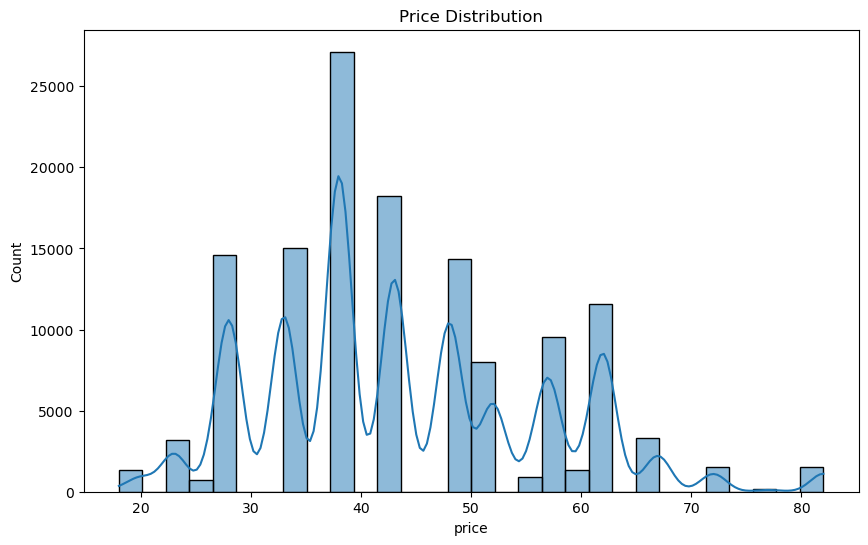

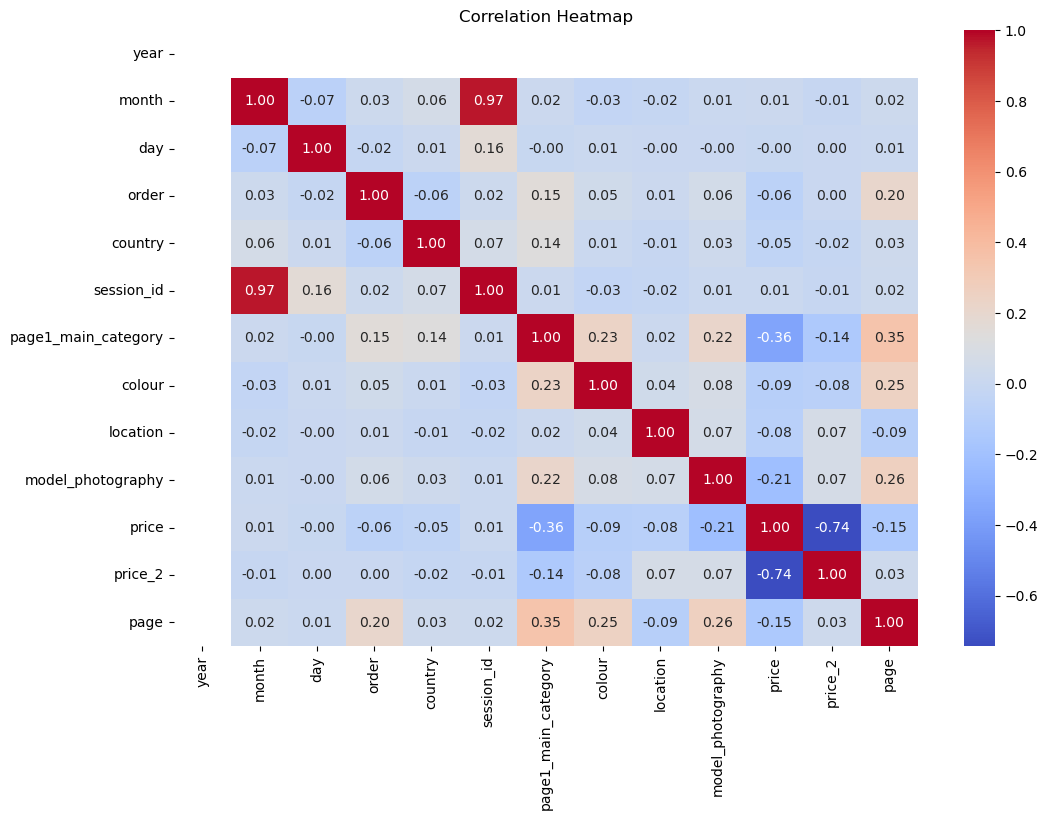


--- Regression Models ---

Linear Regression Results:
MAE: 6.13
MSE: 60.25
RMSE: 7.76
R² Score: 0.62

Random Forest Regressor Results:
MAE: 0.19
MSE: 1.32
RMSE: 1.15
R² Score: 0.99

Gradient Boosting Regressor Results:
MAE: 3.10
MSE: 15.86
RMSE: 3.98
R² Score: 0.90

✅ Best Regression Model Selected: Random Forest Regressor

--- Hyperparameter Tuning: Random Forest Regressor ---
✅ Best Parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}

--- Evaluating Tuned Regression Model on Test Set ---
MAE: 0.20
MSE: 1.19
RMSE: 1.09
R² Score: 0.99

--- Predicting with Best Regression Model ---
Predicted Values (Regression):
 [33. 33. 28. ... 48. 48. 33.]
   Predicted_Price
0             33.0
1             33.0
2             28.0
3             57.0
4             43.0
Remaining dtypes in X: bool       28
float64     9
Name: count, dtype: int64
Any object columns? []

--- Classification Models ---
Remaining dtypes in X: bool       28
float64     9
Name: count, dtype: int64
Any 

C:\Users\HP\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:12:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Results:
[[20290    26]
 [   22 20291]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     20316
         1.0       1.00      1.00      1.00     20313

    accuracy                           1.00     40629
   macro avg       1.00      1.00      1.00     40629
weighted avg       1.00      1.00      1.00     40629



In [ ]:
pipeline = MLProjectPipeline(None)

# Run regression
regression_results = pipeline.run_regression_pipeline(
    "C:/Users/HP/Desktop/kani/Data_science/guvi/Project/Clickstream_data/train_data.csv",
    "C:/Users/HP/Desktop/kani/Data_science/guvi/Project/Clickstream_data/test_data.csv"
)
print(regression_results.head())

# Run classification
classification_results = pipeline.run_classification_pipeline(
     "C:/Users/HP/Desktop/kani/Data_science/guvi/Project/Clickstream_data/train_data.csv",
    "C:/Users/HP/Desktop/kani/Data_science/guvi/Project/Clickstream_data/test_data.csv"
)

# Run clustering
clustering_results = pipeline.run_clustering_pipeline(
     "C:/Users/HP/Desktop/kani/Data_science/guvi/Project/Clickstream_data/train_data.csv",
    "C:/Users/HP/Desktop/kani/Data_science/guvi/Project/Clickstream_data/test_data.csv"
)


Remaining dtypes in X: bool       28
float64     9
Name: count, dtype: int64
Any object columns? []

--- Classification Models ---
Remaining dtypes in X: bool       28
float64     9
Name: count, dtype: int64
Any object columns? []

Logistic Regression Results:
[[ 9812 10504]
 [ 8253 12060]]
              precision    recall  f1-score   support

         0.0       0.54      0.48      0.51     20316
         1.0       0.53      0.59      0.56     20313

    accuracy                           0.54     40629
   macro avg       0.54      0.54      0.54     40629
weighted avg       0.54      0.54      0.54     40629


Decision Tree Results:
[[20292    24]
 [   23 20290]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     20316
         1.0       1.00      1.00      1.00     20313

    accuracy                           1.00     40629
   macro avg       1.00      1.00      1.00     40629
weighted avg       1.00      1.00      1.00     40629


C:\Users\HP\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:06:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Results:
[[20290    26]
 [   22 20291]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     20316
         1.0       1.00      1.00      1.00     20313

    accuracy                           1.00     40629
   macro avg       1.00      1.00      1.00     40629
weighted avg       1.00      1.00      1.00     40629



C:\Users\HP\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



Neural Network Results:
[[19668   648]
 [ 6156 14157]]
              precision    recall  f1-score   support

         0.0       0.76      0.97      0.85     20316
         1.0       0.96      0.70      0.81     20313

    accuracy                           0.83     40629
   macro avg       0.86      0.83      0.83     40629
weighted avg       0.86      0.83      0.83     40629



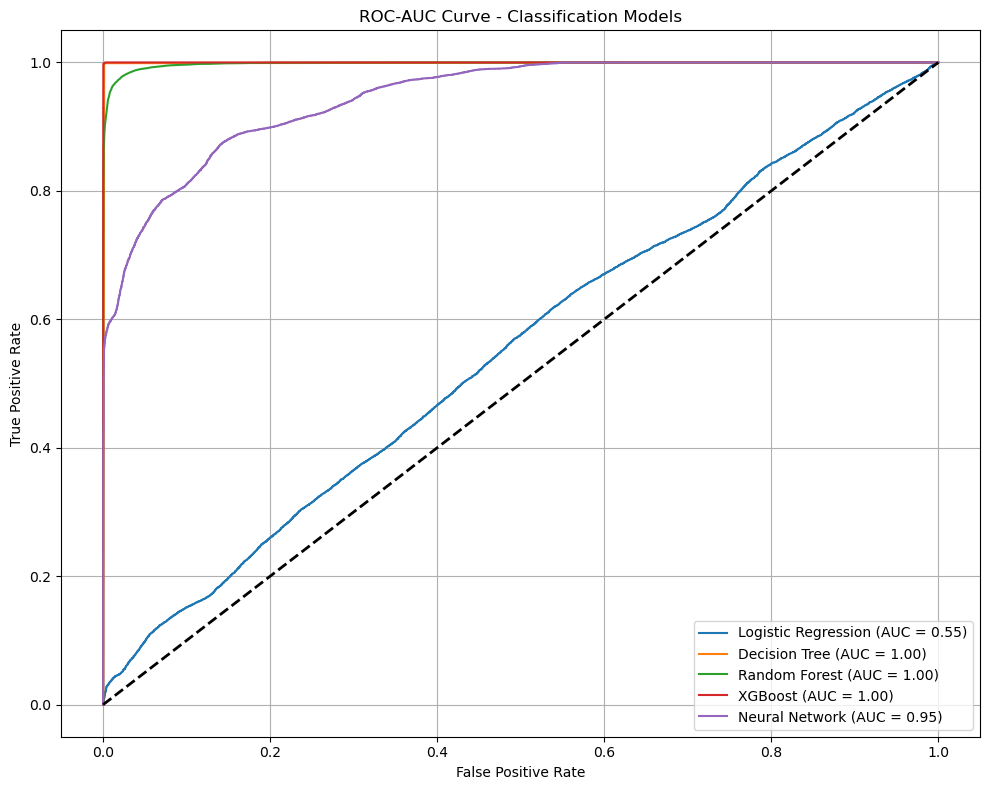


--- Tuning and Selecting Best Classification Model ---

Tuning Logistic Regression...
Logistic Regression Best F1 Score: 0.5803
Best Params: {'C': 0.01, 'solver': 'liblinear'}

Tuning Random Forest...
Random Forest Best F1 Score: 0.9808
Best Params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}

Tuning XGBoost...


C:\Users\HP\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:11:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Best F1 Score: 0.9987
Best Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}

Best Model Selected: XGBoost (F1 Score = 0.9987)

Final Test Evaluation:
[[20311     5]
 [   47 20266]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     20316
         1.0       1.00      1.00      1.00     20313

    accuracy                           1.00     40629
   macro avg       1.00      1.00      1.00     40629
weighted avg       1.00      1.00      1.00     40629



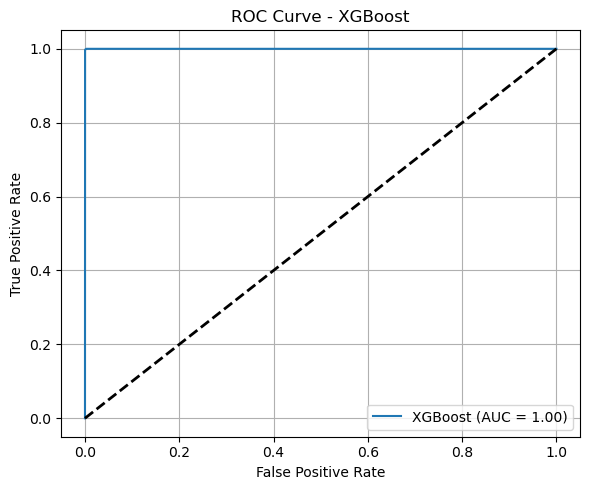


--- Predicting with Best Classification Model ---
Predicted Classes:
 [0 0 0 ... 0 1 0]
Prediction Probabilities:
 [0.01357487 0.00188392 0.12177678 ... 0.15652972 0.9243852  0.05465173]


In [3]:
pipeline = MLProjectPipeline(None)
# Run classification
classification_results = pipeline.run_classification_pipeline(
     "C:/Users/HP/Desktop/kani/Data_science/guvi/Project/Clickstream_data/train_data.csv",
    "C:/Users/HP/Desktop/kani/Data_science/guvi/Project/Clickstream_data/test_data.csv"
)


--- Clustering Evaluation ---

KMeans Results:
Within-Cluster Sum of Squares (WCSS): 12620.04
Silhouette Score: 0.68
Davies-Bouldin Index: 0.62

DBSCAN Results:
Could not compute metrics for DBSCAN: 

Agglomerative Results:
Could not compute metrics for Agglomerative: Unable to allocate 65.3 GiB for an array with shape (8762033631,) and data type float64

--- KMeans Tuning ---
KMeans (k=2): Silhouette = 0.554
KMeans (k=3): Silhouette = 0.676
KMeans (k=4): Silhouette = 0.775
KMeans (k=5): Silhouette = 0.650


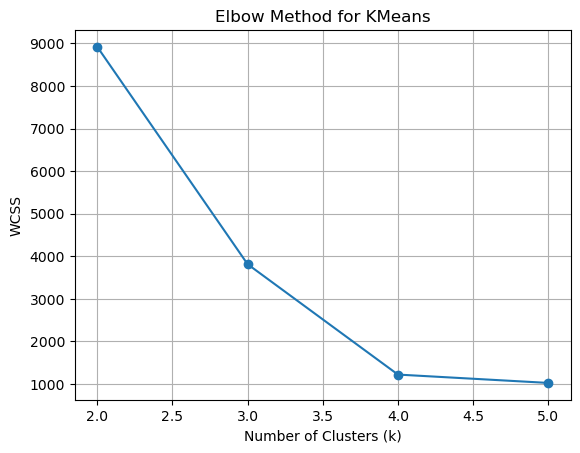


--- DBSCAN Tuning ---
DBSCAN (eps=0.3, min_samples=5): Silhouette=0.775, DBI=0.348
DBSCAN (eps=0.3, min_samples=10): Silhouette=0.775, DBI=0.348
DBSCAN (eps=0.5, min_samples=5): Silhouette=0.775, DBI=0.348
DBSCAN (eps=0.5, min_samples=10): Silhouette=0.775, DBI=0.348
DBSCAN (eps=0.7, min_samples=5): Silhouette=0.775, DBI=0.348
DBSCAN (eps=0.7, min_samples=10): Silhouette=0.775, DBI=0.348

Best DBSCAN => eps=0.3, min_samples=5, Silhouette=0.775, DB Index=0.348

--- Clustering Model Selection ---
Selected Model: KMeans (k=4) with Silhouette=0.775, DB Index=0.348

--- Cluster Profile Summary ---

Cluster Sizes:
Cluster_Label
0    45709
1    52248
2    18956
3    15466
Name: count, dtype: int64

Cluster Feature Means:
               year     month       day     order   country  session_id  \
Cluster_Label                                                             
0               0.0  0.391750  0.450666  0.043626  0.559639    0.497938   
1               0.0  0.395436  0.450049  0.042490 

C:\Users\HP\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


In [4]:
pipeline = MLProjectPipeline(None)
# Run clustering
clustering_results = pipeline.run_clustering_pipeline(
     "C:/Users/HP/Desktop/kani/Data_science/guvi/Project/Clickstream_data/train_data.csv",
    "C:/Users/HP/Desktop/kani/Data_science/guvi/Project/Clickstream_data/test_data.csv"
)